In [1]:
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

greens = matplotlib.cm.get_cmap('Greens')
reds = matplotlib.cm.get_cmap('Reds')
blues = matplotlib.cm.get_cmap('Blues')

from agrifoodpy.population.population_data import UN
from agrifoodpy.food.food_supply import FAOSTAT, Nutrients_FAOSTAT, scale_food, plot_bars
from agrifoodpy.impact.impact import PN18_FAOSTAT


In [2]:
UN

<xarray.Dataset>
Dimensions:              (Year: 151, Region: 477)
Coordinates:
  * Year                 (Year) int64 1950 1951 1952 1953 ... 2098 2099 2100
  * Region               (Region) int64 4 903 1823 1560 ... 1801 887 894 716
Data variables: (12/14)
    Medium               (Year, Region) float32 ...
    High                 (Year, Region) float32 ...
    Low                  (Year, Region) float32 ...
    Constant fertility   (Year, Region) float32 ...
    Instant replacement  (Year, Region) float32 ...
    Zero migration       (Year, Region) float32 ...
    ...                   ...
    Momentum             (Year, Region) float32 ...
    Median PI            (Year, Region) float32 ...
    Upper 80 PI          (Year, Region) float32 ...
    Lower 80 PI          (Year, Region) float32 ...
    Upper 95 PI          (Year, Region) float32 ...
    Lower 95 PI          (Year, Region) float32 ...

In [3]:
FAOSTAT

<xarray.Dataset>
Dimensions:      (Region: 224, Year: 59, Item: 117)
Coordinates:
  * Region       (Region) int64 1 2 3 4 7 8 9 ... 5707 5801 5802 5803 5815 5817
    Region_name  (Region) object ...
  * Year         (Year) int64 1961 1962 1963 1964 1965 ... 2016 2017 2018 2019
  * Item         (Item) int64 2511 2513 2514 2515 2516 ... 2948 2949 2960 2961
    Item_name    (Item) object ...
    Item_group   (Item) object ...
    Item_origin  (Item) object ...
Data variables: (12/13)
    stock        (Region, Year, Item) float32 ...
    losses       (Region, Year, Item) float32 ...
    processing   (Region, Year, Item) float32 ...
    food         (Region, Year, Item) float32 ...
    other        (Region, Year, Item) float32 ...
    residual     (Region, Year, Item) float32 ...
    ...           ...
    domestic     (Region, Year, Item) float32 ...
    production   (Region, Year, Item) float32 ...
    feed         (Region, Year, Item) float32 ...
    seed         (Region, Year, Item) float32 ...
    imports      (Region, Year, Item) float32 ...
    exports      (Region, Year, Item) float32 ...

In [4]:
# Plant based energy intake scaling - 
# Animal origin products are scaled to keep energy instake constant

plant_scaling = 1.3

In [5]:
# area = 10 #Australia
area_pop = 826 #UK
area_fao = 229 #UK

# Select a year from the 1961-2019 range
years = 2019

In [6]:
population = UN.Medium.sel(Region=area_pop, Year=years)*1000

In [7]:
co2e_g = PN18_FAOSTAT["GHG Emissions"]/1000

In [8]:
groups = {
    "Cereals" : np.array([2511, 2513, 2514, 2515, 2516, 2517, 2518, 2520, 2531, 2532, 2533, 2534, 2535, 2807]),
    "Pulses" : np.array([2546, 2547, 2549, 2555]),
    "Sugar" : np.array([2536, 2537, 2541, 2542, 2543, 2558, 2562, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2586, 2745]),
    "NutsSeed" : np.array([2551, 2552, 2557, 2560, 2561]),
    "VegetablesFruits" : np.array([2563, 2601, 2602, 2605, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2625, 2641, 2775]),
    "RuminantMeat" : np.array([2731, 2732]),
    "OtherMeat" : np.array([2733, 2734, 2735, 2736]),
    "Egg" : np.array([2949]),
    "Dairy" : np.array([2740, 2743, 2948]),
    "FishSeafood" : np.array([2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769]),
    "Other" : np.array([2630, 2633, 2635, 2640, 2642, 2645, 2655, 2656, 2657, 2658, 2680, 2737]),
    "NonFood" : np.array([2559, 2575, 2659, 2781, 2782])
}

items_uk = np.hstack(list(groups.values()))

group_labels = []
group_names = list(groups.keys())

for item in items_uk:
    for ig, group in enumerate(group_names):
        if item in groups[group]:
            group_labels.append(list(groups.keys())[ig])

In [9]:
print(area_fao, items_uk, years)

229 [2511 2513 2514 2515 2516 2517 2518 2520 2531 2532 2533 2534 2535 2807
 2546 2547 2549 2555 2536 2537 2541 2542 2543 2558 2562 2570 2571 2572
 2573 2574 2576 2577 2578 2579 2580 2581 2582 2586 2745 2551 2552 2557
 2560 2561 2563 2601 2602 2605 2611 2612 2613 2614 2615 2616 2617 2618
 2619 2620 2625 2641 2775 2731 2732 2733 2734 2735 2736 2949 2740 2743
 2948 2761 2762 2763 2764 2765 2766 2767 2768 2769 2630 2633 2635 2640
 2642 2645 2655 2656 2657 2658 2680 2737 2559 2575 2659 2781 2782] 2019


In [10]:
food_uk = FAOSTAT.sel(Region=area_fao, Item=items_uk, Year=years).drop("domestic")

kcal_day = Nutrients_FAOSTAT["kcal"].sel(Item=items_uk, Region=area_fao, Year=years)
prot_day = Nutrients_FAOSTAT["protein"].sel(Item=items_uk, Region=area_fao, Year=years)
fats_day = Nutrients_FAOSTAT["fat"].sel(Item=items_uk, Region=area_fao, Year=years)

food_uk = food_uk*1e9/population/365.25

food_uk = food_uk.assign_coords(dict(group=("Item", group_labels)))

In [11]:
food_uk

<xarray.Dataset>
Dimensions:      (Item: 97)
Coordinates:
    Region_name  object ...
    Year         int64 2019
  * Item         (Item) int64 2511 2513 2514 2515 2516 ... 2575 2659 2781 2782
    Item_name    (Item) object ...
    Item_group   (Item) object ...
    Item_origin  (Item) object ...
    group        (Item) <U16 'Cereals' 'Cereals' ... 'NonFood' 'NonFood'
Data variables:
    stock        (Item) float64 24.81 28.7 14.43 0.0 1.784 ... 0.0 0.0 nan 0.0
    losses       (Item) float64 3.284 1.622 1.135 0.08109 ... nan nan nan nan
    processing   (Item) float64 16.5 60.77 35.03 nan nan ... nan nan nan nan nan
    food         (Item) float64 304.4 1.419 11.6 1.541 20.11 ... 0.0 nan 0.0 0.0
    other        (Item) float64 31.83 nan 19.87 nan nan ... nan 22.87 0.6341 0.0
    residual     (Item) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan nan
    tourist      (Item) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    production   (Item) float64 657.8 326.3 0.0 3.041 ... nan nan 0.4764 0.03649
    feed         (Item) float64 298.4 153.5 29.39 1.46 ... nan 0.2027 0.04054
    seed         (Item) float64 11.39 7.622 nan 0.1216 1.014 ... nan nan nan nan
    imports      (Item) float64 102.2 5.676 118.7 ... 29.11 0.7995 0.04257
    exports      (Item) float64 69.49 78.33 7.217 ... 6.203 0.4391 0.03852

In [12]:
kcal_g = kcal_day / food_uk["food"]
prot_g = prot_day / food_uk["food"]
fats_g = fats_day / food_uk["food"]

kcal_day_food_uk = food_uk * kcal_g
prot_day_food_uk = food_uk * prot_g
fats_day_food_uk = food_uk * fats_g
co2e_day_food_uk = food_uk * co2e_g

kcal_day_food_uk = kcal_day_food_uk.where(np.isfinite(kcal_day_food_uk), other=0)
prot_day_food_uk = prot_day_food_uk.where(np.isfinite(prot_day_food_uk), other=0)
fats_day_food_uk = fats_day_food_uk.where(np.isfinite(fats_day_food_uk), other=0)
co2e_day_food_uk = co2e_day_food_uk.where(np.isfinite(co2e_day_food_uk), other=0)
# food_uk = food_uk.where(np.isfinite(food_uk), other=0)

In [13]:
kcal_day_food_uk_group = kcal_day_food_uk.groupby("group").sum().rename({"group":"Item"}).sel(Item=list(groups.keys()))
prot_day_food_uk_group = prot_day_food_uk.groupby("group").sum().rename({"group":"Item"}).sel(Item=list(groups.keys()))
fats_day_food_uk_group = fats_day_food_uk.groupby("group").sum().rename({"group":"Item"}).sel(Item=list(groups.keys()))
co2e_day_food_uk_group = co2e_day_food_uk.groupby("group").sum().rename({"group":"Item"}).sel(Item=list(groups.keys()))

food_uk_group = food_uk.groupby("group").sum().rename({"group":"Item"})
food_uk_group = food_uk_group.sel(Item=list(groups.keys()))
food_uk_group

<xarray.Dataset>
Dimensions:      (Item: 12)
Coordinates:
    Region_name  <U52 'United Kingdom of Great Britain and Northern Ireland'
    Year         int64 2019
  * Item         (Item) object 'Cereals' 'Pulses' 'Sugar' ... 'Other' 'NonFood'
Data variables:
    stock        (Item) float64 75.25 -1.297 15.65 1.014 ... 0.446 0.0 3.811 0.0
    losses       (Item) float64 10.78 1.865 21.73 0.0 ... 0.0 0.0 0.6081 0.0
    processing   (Item) float64 116.6 27.65 355.2 0.0 ... 142.8 0.0 5.473 0.0
    food         (Item) float64 571.8 8.879 143.1 11.6 ... 583.0 50.66 263.6 0.0
    other        (Item) float64 57.89 0.0 66.9 0.0 ... 0.0 0.04784 1.946 23.5
    residual     (Item) float64 0.0 0.0 -0.08109 0.0 ... 0.0 0.0 -0.1216 0.0
    tourist      (Item) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    production   (Item) float64 1.248e+03 38.03 481.8 0.0 ... 38.89 215.4 0.5129
    feed         (Item) float64 506.0 25.22 3.568 1.378 ... 9.381 0.0 0.2433
    seed         (Item) float64 35.07 2.311 0.3649 0.0 0.0 ... 0.0 0.0 0.0 0.0
    imports      (Item) float64 310.4 38.88 180.1 15.37 ... 64.18 144.5 29.95
    exports      (Item) float64 185.0 12.24 55.62 1.338 ... 42.98 84.61 6.681

In [14]:
# Food groups are classified into plant and animal origin

plant_mask = np.arange(5)
animal_mask = np.arange(5, 10)
other_mask = np.arange(10, 12)

green_colors = greens(1/(2+plant_mask))
red_colors = reds(1/(2+animal_mask-5))
blue_colors = blues([0.5,1])

colors = np.concatenate((green_colors, red_colors, blue_colors))

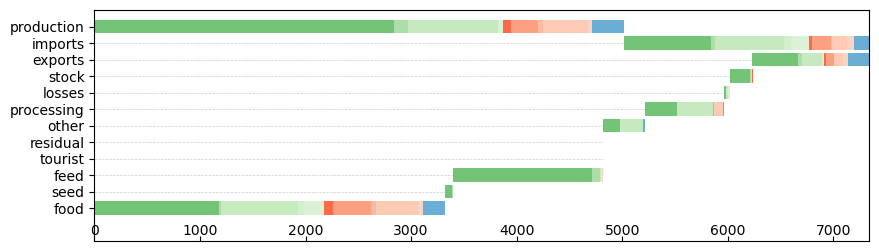

In [15]:
plot_bars(kcal_day_food_uk_group, colors = colors, figsize=(10,3));

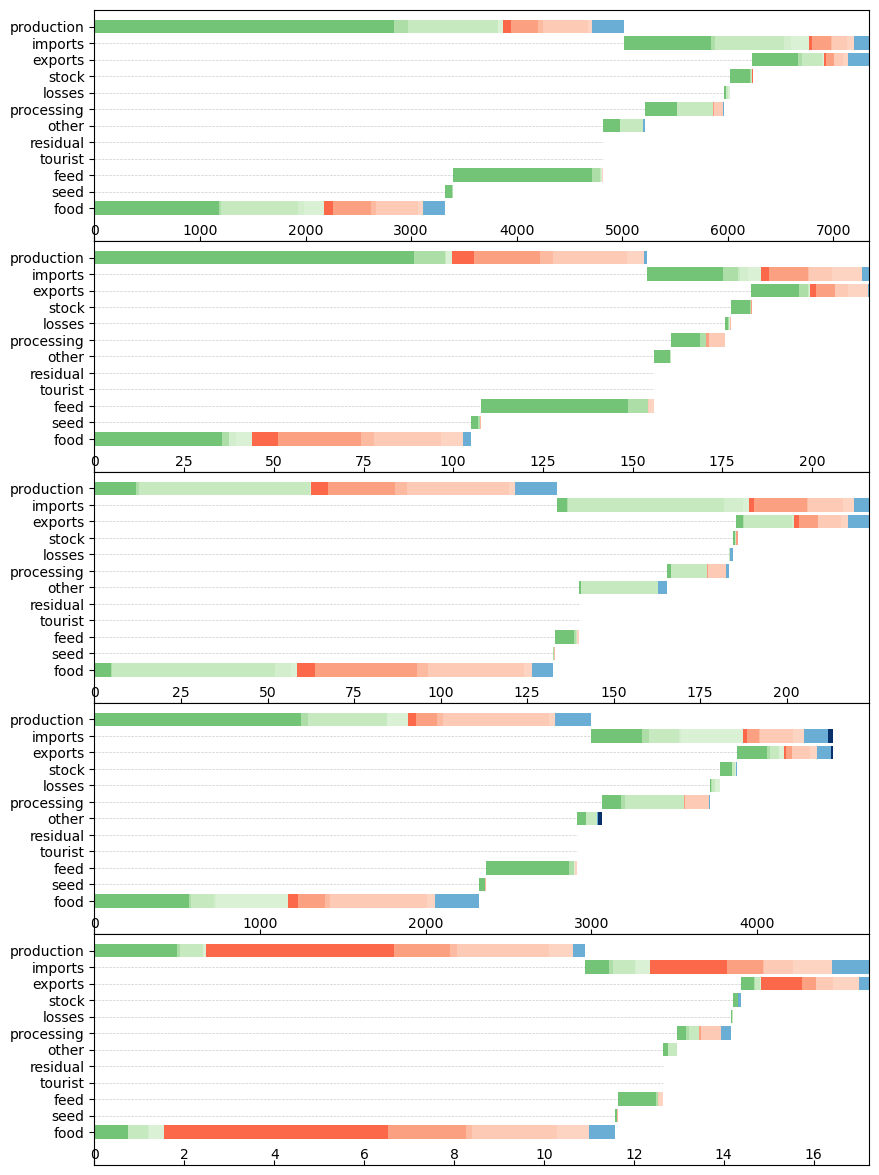

In [16]:
to_plot = [kcal_day_food_uk_group,
           prot_day_food_uk_group,
           fats_day_food_uk_group,
           food_uk_group,
           co2e_day_food_uk_group]

f, axes = plt.subplots(5, figsize=(10, 3*5))
plt.subplots_adjust(hspace=0)

for food, ax in zip(to_plot, axes):
    plot_bars(food, ax=ax, colors=colors)

In [17]:
origin = "imports"
fallback = "exports"
plant_items = ["Cereals", "Pulses", "Sugar", "NutsSeed", "VegetablesFruits"]
food = kcal_day_food_uk_group
out_kcal_day_food_uk_group = scale_food(food=food, scale=plant_scaling, origin=origin, items=plant_items, constant=True, fallback=fallback)

In [18]:
scaling = out_kcal_day_food_uk_group/kcal_day_food_uk_group
scaling = scaling.fillna(0)

out_food_uk_group = food_uk_group * scaling
out_prot_day_food_uk_group = prot_day_food_uk_group * scaling
out_fats_day_food_uk_group = fats_day_food_uk_group * scaling
out_co2e_day_food_uk_group = co2e_day_food_uk_group * scaling

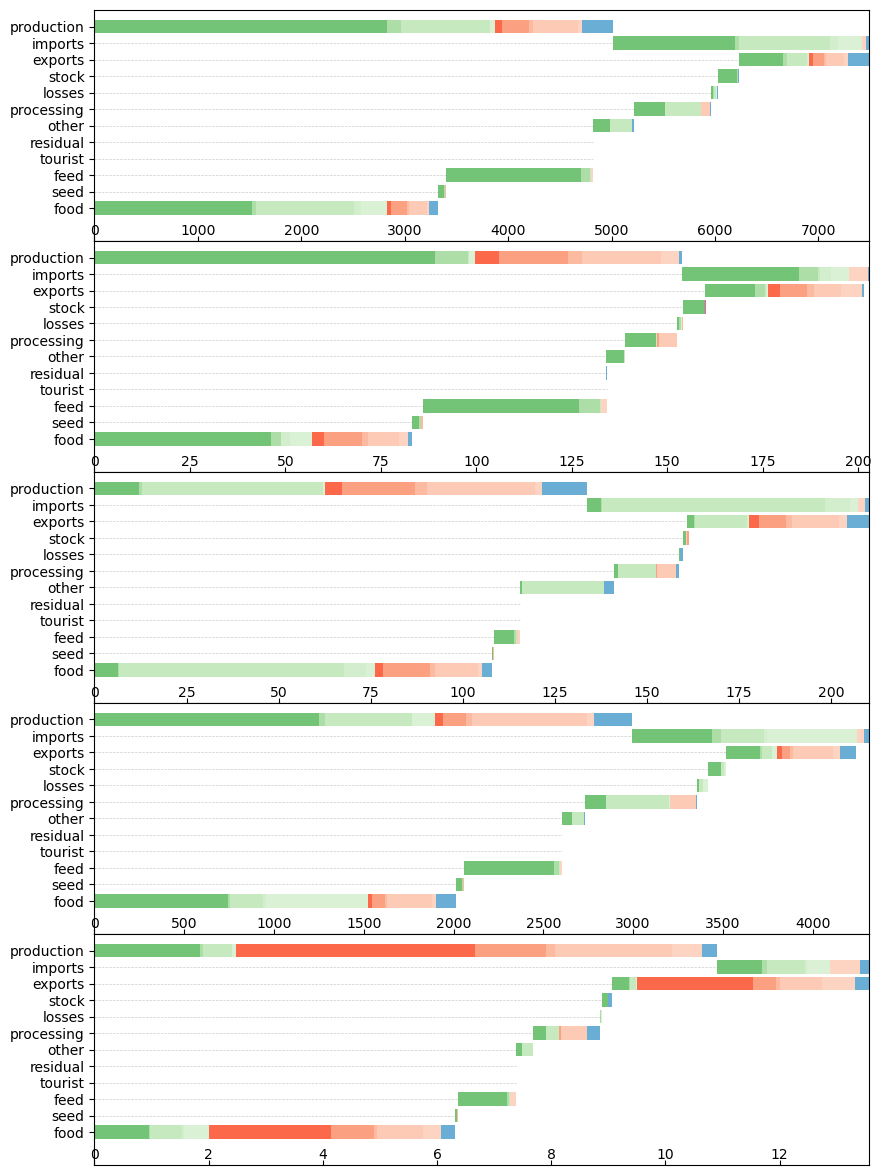

In [19]:
to_plot = [out_kcal_day_food_uk_group, 
           out_prot_day_food_uk_group, 
           out_fats_day_food_uk_group, 
           out_food_uk_group, 
           out_co2e_day_food_uk_group]

f, axes = plt.subplots(5, figsize=(10, 3*5))
plt.subplots_adjust(hspace=0)

for food, ax in zip(to_plot, axes):
    plot_bars(food, ax=ax, colors=colors)

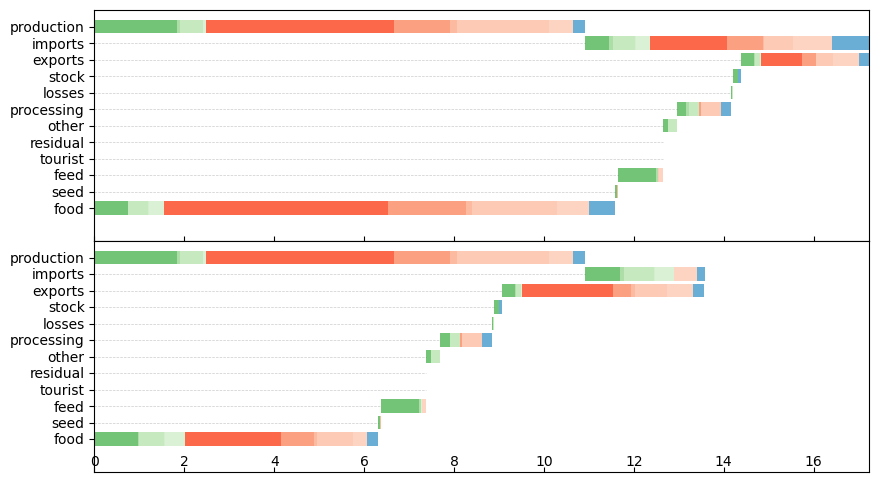

In [20]:
to_plot = [co2e_day_food_uk_group, 
           out_co2e_day_food_uk_group]

f, axes = plt.subplots(2, figsize=(10, 3*2), sharex=True)
plt.subplots_adjust(hspace=0)

for food, ax in zip(to_plot, axes):
    plot_bars(food, ax=ax, colors=colors)
